In [1]:
import pandas as pd

In [2]:
file_path = 'data.xlsx'  # Ensure this file is in the same directory or provide the full path
df = pd.read_excel(file_path)

1. Data Preprocessing

In [4]:
df.shape
print(df.shape)
# Column descriptions
print("\nColumn Descriptions:")
print(df.info())  # Summary of columns, data types, and missing values

print("\nSample Data:")
print(df.head())  # Display the first few rows of the dataset

# Step 3: Handle missing values
# Display missing value counts for each column
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# Remove rows with any missing values
df = df.dropna(axis=0)  # Removes rows with missing data
print("\nShape after dropping rows with missing values:", df.shape)

# Step 4: Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Step 5: Determine the period covered by the dataset based on 'InvoiceDate'
print("\nDataset Period (based on 'InvoiceDate'):")
start_date = df['InvoiceDate'].min()
end_date = df['InvoiceDate'].max()

print("Start Date:", start_date)
print("End Date:", end_date)




(541909, 8)

Column Descriptions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Sample Data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTT

2. RFM Calculation

In [6]:
# Step 2: Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Step 3: Create the Monetary Value (Total Price for each transaction)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Step 4: Calculate Recency, Frequency, and Monetary metrics

# Recency: The number of days since the last purchase for each customer
# We will use the max date in the dataset as the reference point
current_date = df['InvoiceDate'].max()  # Latest date in the dataset
recency_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days  # Calculate days since last purchase
}).reset_index()
recency_df.rename(columns={'InvoiceDate': 'Recency'}, inplace=True)

# Frequency: The total number of unique purchases (invoices) per customer
frequency_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique'  # Count unique invoices for each customer
}).reset_index()
frequency_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Monetary: The total monetary value spent by each customer
monetary_df = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum'  # Sum of total price per customer
}).reset_index()
monetary_df.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

# Step 5: Merge the three dataframes to get the final RFM table
rfm_df = recency_df.merge(frequency_df, on='CustomerID', how='left')
rfm_df = rfm_df.merge(monetary_df, on='CustomerID', how='left')

# Step 6: Remove decimal points from CustomerID (convert to integers)
rfm_df['CustomerID'] = rfm_df['CustomerID'].astype(int)

# Step 7: Display the RFM dataframe
print(rfm_df.head())




   CustomerID  Recency  Frequency  Monetary
0       12346      326          2      0.00
1       12347       40          7   4310.00
2       12348       76          4   1797.24
3       12349       19          1   1757.55
4       12350      311          1    334.40


In [7]:
3.

3.0

3. RFM Segmentation:

In [9]:
# Recency score: Lower recency values (more recent purchases) are better
recency_quartiles = rfm_df['Recency'].quantile([0.25, 0.5, 0.75])
rfm_df['RecencyScore'] = rfm_df['Recency'].apply(
    lambda x: 4 if x <= recency_quartiles[0.25] else 
              3 if x <= recency_quartiles[0.50] else 
              2 if x <= recency_quartiles[0.75] else 1
)

# Frequency score: Higher frequency values (more purchases) are better
frequency_quartiles = rfm_df['Frequency'].quantile([0.25, 0.5, 0.75])
rfm_df['FrequencyScore'] = rfm_df['Frequency'].apply(
    lambda x: 1 if x <= frequency_quartiles[0.25] else 
              2 if x <= frequency_quartiles[0.50] else 
              3 if x <= frequency_quartiles[0.75] else 4
)

# Monetary score: Higher monetary values (more spending) are better
monetary_quartiles = rfm_df['Monetary'].quantile([0.25, 0.5, 0.75])
rfm_df['MonetaryScore'] = rfm_df['Monetary'].apply(
    lambda x: 1 if x <= monetary_quartiles[0.25] else 
              2 if x <= monetary_quartiles[0.50] else 
              3 if x <= monetary_quartiles[0.75] else 4
)

# Combine RFM scores into a single RFM score
rfm_df['RFMScore'] = (
    rfm_df['RecencyScore'].astype(str) + 
    rfm_df['FrequencyScore'].astype(str) + 
    rfm_df['MonetaryScore'].astype(str)
)

# Display the updated RFM dataframe
print(rfm_df.head())


   CustomerID  Recency  Frequency  Monetary  RecencyScore  FrequencyScore  \
0       12346      326          2      0.00             1               2   
1       12347       40          7   4310.00             3               4   
2       12348       76          4   1797.24             2               3   
3       12349       19          1   1757.55             4               1   
4       12350      311          1    334.40             1               1   

   MonetaryScore RFMScore  
0              1      121  
1              4      344  
2              4      234  
3              4      414  
4              2      112  


In [10]:
# Combine RFM scores into a single RFM score
rfm_df['RFMScore'] = (
    rfm_df['RecencyScore'].astype(str) + 
    rfm_df['FrequencyScore'].astype(str) + 
    rfm_df['MonetaryScore'].astype(str)
)

# Display the updated RFM dataframe with the combined RFM score
print(rfm_df[['CustomerID', 'RecencyScore', 'FrequencyScore', 'MonetaryScore', 'RFMScore']].head())


   CustomerID  RecencyScore  FrequencyScore  MonetaryScore RFMScore
0       12346             1               2              1      121
1       12347             3               4              4      344
2       12348             2               3              4      234
3       12349             4               1              4      414
4       12350             1               1              2      112


4. Customer Segmentation:

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for clustering
rfm_clustering = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)


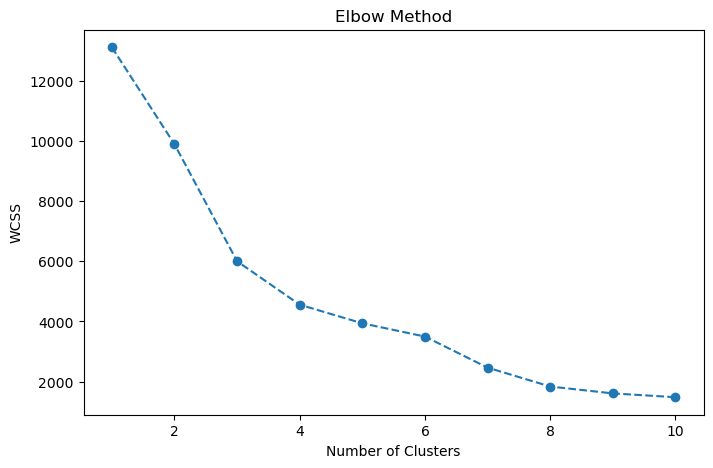

In [13]:
wcss = []
for i in range(1, 11):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [14]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Map clusters to 1-based index (optional)
rfm_df['Cluster'] += 1


In [15]:
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'CustomerCount'})

print(cluster_summary)


            Recency   Frequency       Monetary  CustomerCount
Cluster                                                      
1         13.097436   28.466667   12110.495231            195
2         50.617110    4.405960    1322.403318           3121
3          5.272727  109.909091  124312.306364             11
4        268.666029    1.606699     424.749397           1045


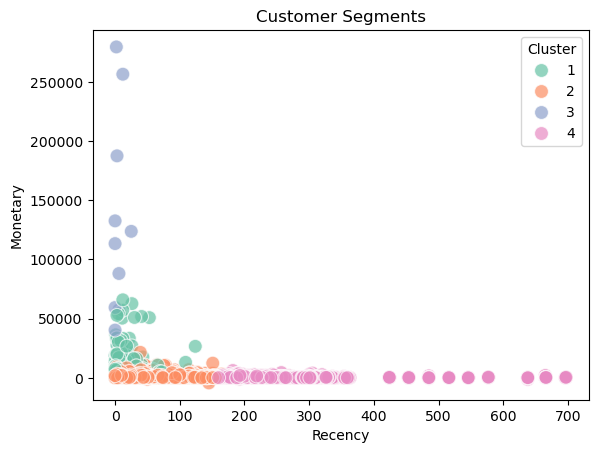

In [16]:
# Visualize clusters in a 2D scatter plot
sns.scatterplot(
    x=rfm_df['Recency'], y=rfm_df['Monetary'],
    hue=rfm_df['Cluster'], palette='Set2', s=100, alpha=0.7
)
plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()


Refining the choice of clusters using the Silhouette Score.

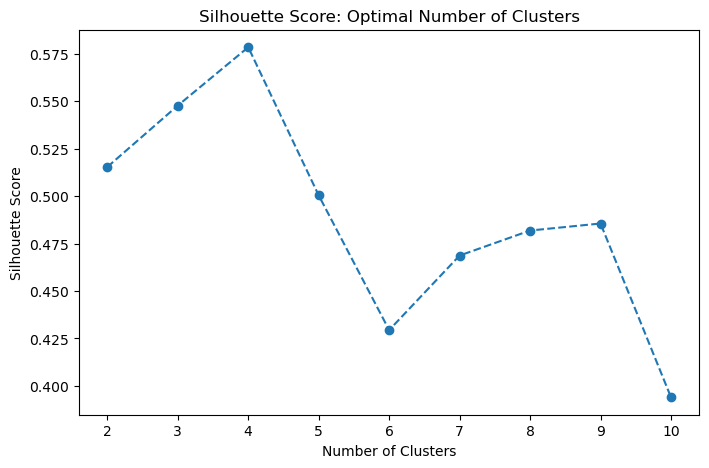

In [18]:
from sklearn.metrics import silhouette_score

# Compute silhouette scores for a range of cluster numbers
silhouette_scores = []
for i in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.show()


5. Segment Profiling:

In [20]:
# Group by clusters and compute mean RFM metrics
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'sum'],
    'CustomerID': 'count'  # Number of customers in each cluster
}).rename(columns={'CustomerID': 'CustomerCount'})

# Flatten multi-index columns for better readability
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns]

# Display the cluster summary
print(cluster_summary)


         Recency_mean  Recency_median  Frequency_mean  Frequency_median  \
Cluster                                                                   
1           13.097436            10.0       28.466667              24.0   
2           50.617110            39.0        4.405960               3.0   
3            5.272727             3.0      109.909091              77.0   
4          268.666029           244.0        1.606699               1.0   

         Monetary_mean  Monetary_median  Monetary_sum  CustomerCount_count  
Cluster                                                                     
1         12110.495231          7904.28   2361546.570                  195  
2          1322.403318           806.90   4127220.754                 3121  
3        124312.306364        113384.14   1367435.370                   11  
4           424.749397           296.75    443863.120                 1045  


Cluster 1: Active High-Spenders
Recency:
Mean: 13.1 days, Median: 10 days
These customers made recent purchases, indicating they are active.
Frequency:
Mean: 28.5 transactions, Median: 24 transactions
They shop frequently compared to other clusters.
Monetary:
Mean: $12,110.50, Median: $7,904.28, Total: $2,361,546.57
They are significant spenders, contributing substantially to total revenue.
Customer Count: 195
Profile:
Loyal, high-value customers who are both active and frequent buyers.
Strategy: Retain this group with exclusive loyalty programs, early product launches, or VIP offers.

Cluster 2: Average Buyers
Recency:
Mean: 50.6 days, Median: 39 days
These customers haven’t purchased as recently but aren’t inactive yet.
Frequency:
Mean: 4.4 transactions, Median: 3 transactions
Moderate frequency of purchases.
Monetary:
Mean: $1,322.40, Median: $806.90, Total: $4,127,220.75
Moderate spenders who contribute a large share of the revenue due to their size.
Customer Count: 3,121
Profile:
A large segment of average customers who purchase occasionally.
Strategy: Engage with personalized offers or seasonal promotions to increase purchase frequency.


Cluster 3: Elite High-Spenders
Recency:
Mean: 5.3 days, Median: 3 days
They have made very recent purchases, showing strong engagement.
Frequency:
Mean: 109.9 transactions, Median: 77 transactions
Exceptionally frequent buyers.
Monetary:
Mean: $124,312.31, Median: $113,384.14, Total: $1,367,435.37
They are extremely high spenders and represent a premium group.
Customer Count: 11
Profile:
Elite, highly engaged customers who generate substantial revenue despite being a small group.
Strategy: Offer exclusive perks, one-on-one customer support, and lifetime value incentives to maintain this relationship.


Cluster 4: Inactive Low-Spenders
Recency:
Mean: 268.7 days, Median: 244 days
They haven’t made purchases for a long time, indicating they are inactive or churned.
Frequency:
Mean: 1.6 transactions, Median: 1 transaction
Low purchase frequency, indicating minimal engagement.
Monetary:
Mean: $424.75, Median: $296.75, Total: $443,863.12
Low spenders with minimal revenue contribution.
Customer Count: 1,045
Profile:
A disengaged group of inactive, low-value customers.
Strategy: Reactivate with win-back campaigns, discounts, or reminders. If unresponsive, focus resources on other segments.

6. Marketing Recommendations:

Cluster 1: Active High-Spenders
Characteristics:

Recent buyers with high frequency and monetary value.
Small but highly profitable segment.
Marketing Strategies:

Exclusive Loyalty Programs:
Offer tier-based loyalty rewards (e.g., free shipping, special discounts).
Early Access:
Provide early access to sales, new product launches, or exclusive collections.
Personalized Engagement:
Use personalized emails or recommendations based on purchase history.
Upselling and Cross-Selling:
Recommend complementary products to maximize spending.
Goal: Retain their loyalty and increase spending through premium offerings.

Cluster 2: Average Buyers
Characteristics:

Moderate frequency, spending, and recency.
Largest segment, representing significant revenue potential.
Marketing Strategies:

Seasonal and Event-Based Campaigns:
Run campaigns during holidays or special events to drive purchases.
Incentivize More Frequent Purchases:
Offer “Buy X, Get Y” or discounts on repeat purchases within a short period.
Customer Referral Program:
Encourage referrals by rewarding them with discounts or credits.
Educational Content:
Send newsletters with tips, usage guides, or product updates to maintain engagement.
Goal: Increase purchase frequency and spending by keeping them engaged and incentivized.

Cluster 3: Elite High-Spenders
Characteristics:

Extremely frequent buyers with very high monetary value.
Small but critical for revenue.
Marketing Strategies:

White-Glove Service:
Offer concierge-like support (e.g., dedicated account manager or hotline).
Exclusive Experiences:
Invite them to VIP events, such as private sales or product previews.
Lifetime Value Incentives:
Provide benefits like free lifetime shipping or anniversary gifts for loyalty.
Build Brand Advocates:
Encourage them to share reviews or testimonials, rewarding them for their advocacy.
Goal: Strengthen emotional connection and long-term loyalty, making them brand ambassadors.

Cluster 4: Inactive Low-Spenders
Characteristics:

Long time since last purchase, with low frequency and spending.
May be churned or at high risk of churn.
Marketing Strategies:

Win-Back Campaigns:
Send targeted emails with subject lines like “We Miss You!” or “Here’s 20% Off to Come Back!”
Exclusive Discounts:
Offer steep discounts or limited-time deals to reignite interest.
Reminder Campaigns:
Notify them of items left in their cart or new arrivals matching past preferences.
Feedback Collection:
Ask why they stopped shopping via surveys or polls, offering an incentive for participation.
Goal: Reactivate this group with strong incentives, and deprioritize unresponsive customers to focus on higher-value segments.

Additional Recommendations:
Dynamic Segmentation: Regularly update customer segments as behaviors change over time.
Omnichannel Outreach: Use email, SMS, social media, and app notifications to engage customers across platforms.
Measure Effectiveness: Track campaign performance metrics (e.g., ROI, response rates) for continuous improvement.
A/B Testing: Experiment with different offers or messages to optimize engagement for each segment.
By implementing these tailored strategies, the business can enhance customer retention, boost revenue, and allocate resources more effectively. Let me know if you’d like further insights on operationalizing these strategies!

7. Visualization:

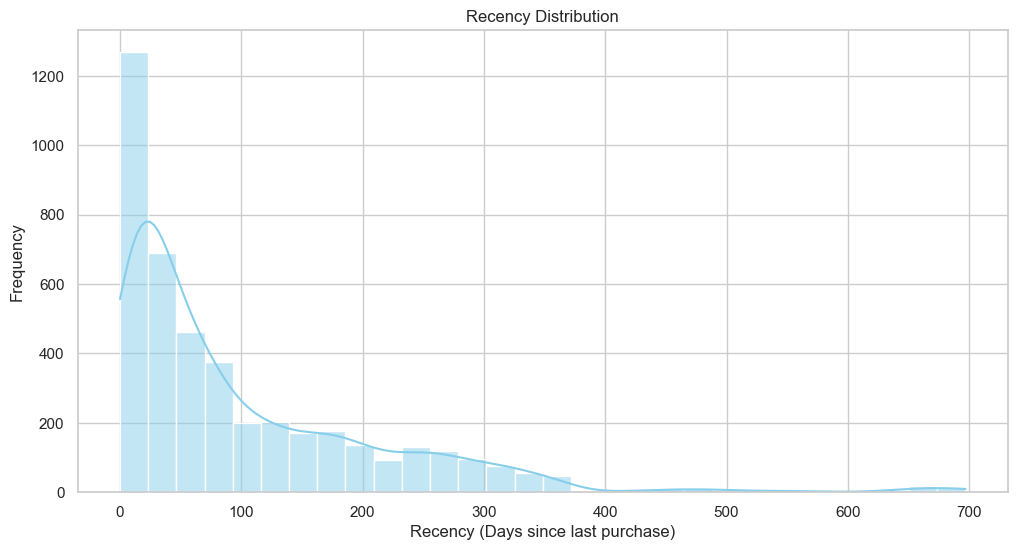

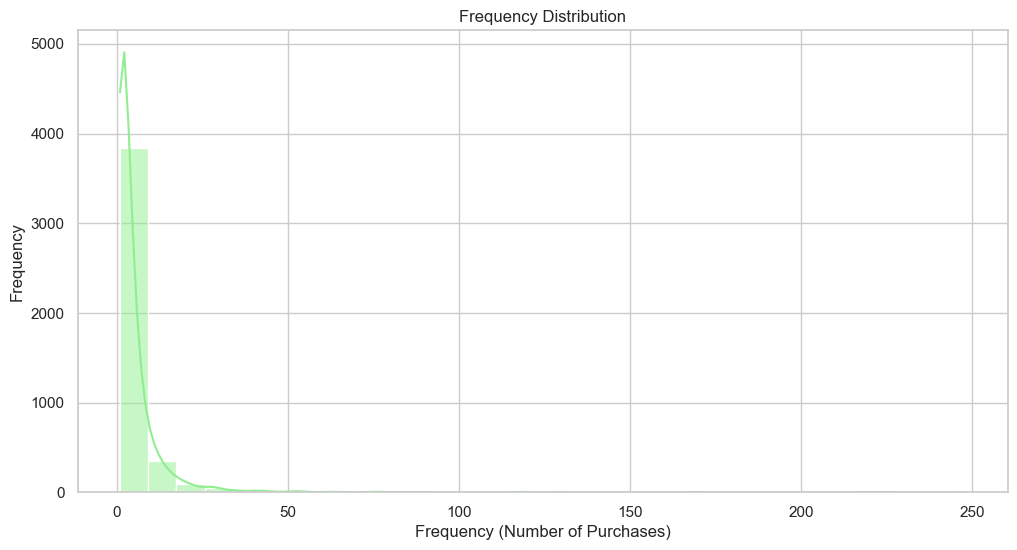

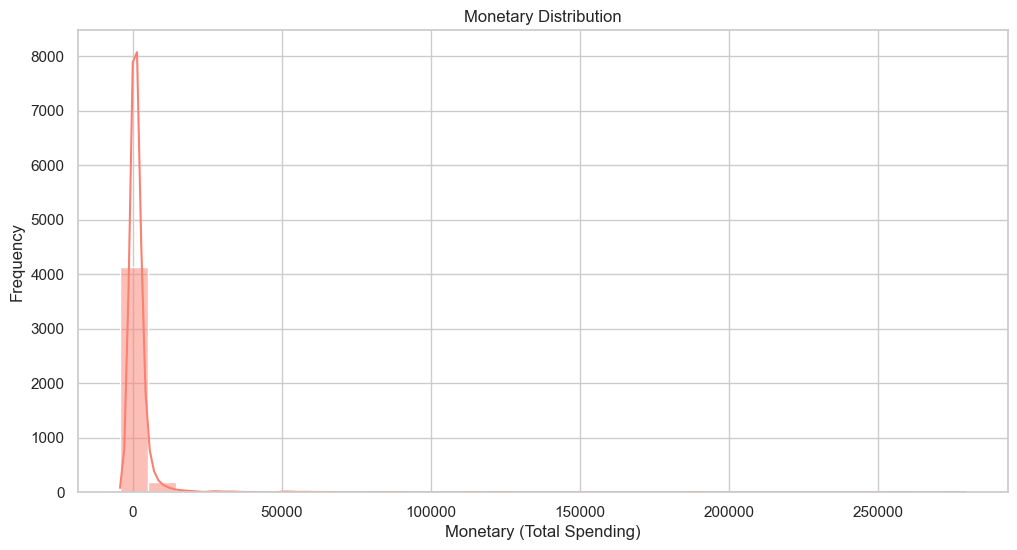

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Plot Recency distribution
plt.figure(figsize=(12, 6))
sns.histplot(rfm_df['Recency'], kde=True, bins=30, color='skyblue')
plt.title('Recency Distribution')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Frequency')
plt.show()

# Plot Frequency distribution
plt.figure(figsize=(12, 6))
sns.histplot(rfm_df['Frequency'], kde=True, bins=30, color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Frequency (Number of Purchases)')
plt.ylabel('Frequency')
plt.show()

# Plot Monetary distribution
plt.figure(figsize=(12, 6))
sns.histplot(rfm_df['Monetary'], kde=True, bins=30, color='salmon')
plt.title('Monetary Distribution')
plt.xlabel('Monetary (Total Spending)')
plt.ylabel('Frequency')
plt.show()


C:\Users\adity\AppData\Local\Temp\ipykernel_19676\1236087702.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm_df, x='RFMScore', palette='viridis')


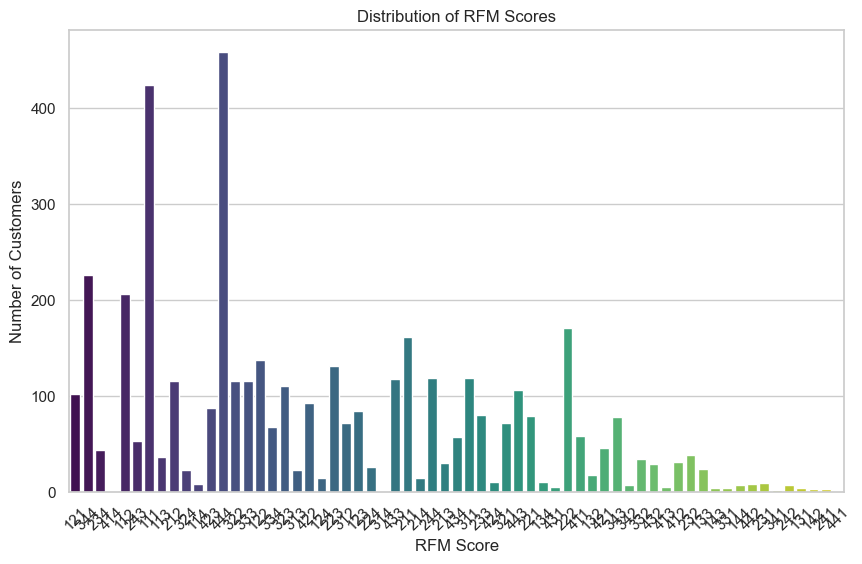

In [33]:
# Combine RFM Score and plot a bar chart for the distribution of RFM scores
rfm_df['RFMScore'] = rfm_df['RecencyScore'].astype(str) + \
                     rfm_df['FrequencyScore'].astype(str) + \
                     rfm_df['MonetaryScore'].astype(str)

plt.figure(figsize=(10, 6))
sns.countplot(data=rfm_df, x='RFMScore', palette='viridis')
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


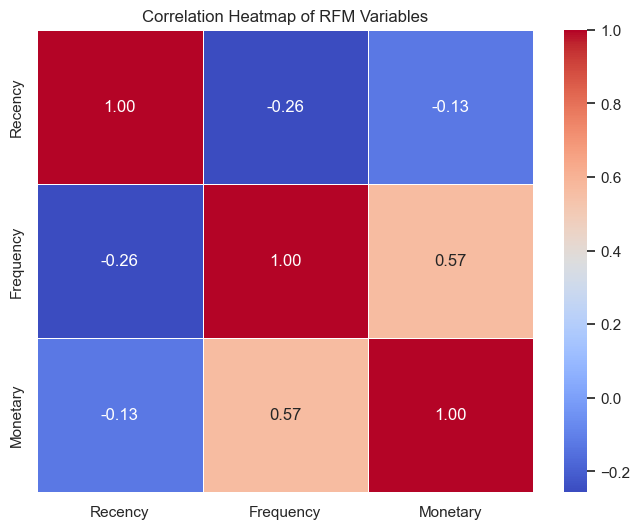

In [34]:
# Compute correlation matrix
rfm_corr = rfm_df[['Recency', 'Frequency', 'Monetary']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of RFM Variables')
plt.show()


2. Customer Analysis

In [37]:
unique_customers = rfm_df['CustomerID'].nunique()
print(f"Number of unique customers: {unique_customers}")


Number of unique customers: 4372


In [58]:
# Distribution of the number of orders per customer (Frequency)
order_distribution = rfm_df['Frequency'].value_counts().sort_index()

# Display the distribution
print(order_distribution)


Frequency
1      1313
2       817
3       490
4       377
5       288
       ... 
118       2
128       1
169       1
224       1
248       1
Name: count, Length: 65, dtype: int64


In [60]:
# Sort the dataframe by Frequency in descending order and select the top 5 customers
top_5_customers = rfm_df.sort_values(by='Frequency', ascending=False).head(5)

# Display the top 5 customers
print(top_5_customers[['CustomerID', 'Frequency']])


      CustomerID  Frequency
1895       14911        248
330        12748        224
4042       17841        169
1674       14606        128
568        13089        118


3. Product Analysis

In [63]:
# Group by 'StockCode' or 'Description' and sum the 'Quantity' for each product
top_10_products = df.groupby('Description').agg({'Quantity': 'sum'}).reset_index()

# Sort the products by total quantity purchased in descending order
top_10_products = top_10_products.sort_values(by='Quantity', ascending=False).head(10)

# Display the top 10 products
print(top_10_products[['Description', 'Quantity']])


                             Description  Quantity
3805   WORLD WAR 2 GLIDERS ASSTD DESIGNS     53215
1771             JUMBO BAG RED RETROSPOT     45066
217        ASSORTED COLOUR BIRD ORNAMENT     35314
3716  WHITE HANGING HEART T-LIGHT HOLDER     34147
2279     PACK OF 72 RETROSPOT CAKE CASES     33409
2612                      POPCORN HOLDER     30504
2669                  RABBIT NIGHT LIGHT     27094
2057             MINI PAINT SET VINTAGE      25880
2245          PACK OF 12 LONDON TISSUES      25321
2277  PACK OF 60 PINK PAISLEY CAKE CASES     24163


In [65]:
# Calculate the average price of products in the dataset
average_price = df['UnitPrice'].mean()

# Display the average price
print(f"The average price of products is: {average_price:.2f}")


The average price of products is: 3.46


In [67]:
# Calculate total revenue for each product
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# If the 'Description' contains category information, you can aggregate by it
# For simplicity, let's assume each product's 'Description' is treated as its category
revenue_by_category = df.groupby('Description').agg({'Revenue': 'sum'}).reset_index()

# Sort the categories by total revenue in descending order to find the highest revenue generator
top_category = revenue_by_category.sort_values(by='Revenue', ascending=False).head(1)

# Display the top product category and its revenue
print(f"The product category generating the highest revenue is: {top_category['Description'].values[0]}")
print(f"Revenue generated by this category: {top_category['Revenue'].values[0]:.2f}")


The product category generating the highest revenue is: REGENCY CAKESTAND 3 TIER
Revenue generated by this category: 132870.40


4. Time Analysis

In [70]:
# Ensure 'InvoiceDate' is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Extract the day of the week and time of day from 'InvoiceDate'
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()  # Day of the week (e.g., Monday, Tuesday)
df['HourOfDay'] = df['InvoiceDate'].dt.hour  # Hour of the day (0-23)

# Find the day of the week with the most orders
orders_by_day = df['DayOfWeek'].value_counts().sort_index()

# Find the hour of the day with the most orders
orders_by_hour = df['HourOfDay'].value_counts().sort_index()

# Display the results
print("Orders by Day of the Week:")
print(orders_by_day)
print("\nOrders by Hour of the Day:")
print(orders_by_hour)


Orders by Day of the Week:
DayOfWeek
Friday       58422
Monday       61754
Saturday     23580
Sunday       62208
Thursday     73267
Tuesday      68358
Wednesday    59240
Name: count, dtype: int64

Orders by Hour of the Day:
HourOfDay
6        41
7       383
8      8792
9     22464
10    38951
11    50249
12    73342
13    65062
14    55075
15    46220
16    24997
17    13734
18     3137
19     3511
20      871
Name: count, dtype: int64


In [72]:
# Calculate the time difference between InvoiceDate and the current date
current_date = pd.to_datetime('today')

# Calculate processing time (in days)
df['OrderProcessingTime'] = (current_date - df['InvoiceDate']).dt.days

# Calculate the average order processing time
average_processing_time = df['OrderProcessingTime'].mean()

# Display the result
print(f"Average Order Processing Time (in days): {average_processing_time:.2f}")


Average Order Processing Time (in days): 4900.33


In [74]:
# Extract the month from the 'InvoiceDate'
df['Month'] = df['InvoiceDate'].dt.month_name()

# Aggregate the total number of orders by month
orders_by_month = df['Month'].value_counts().sort_index()

# Display the results
print("Orders by Month:")
print(orders_by_month)


Orders by Month:
Month
April        27871
August       32329
December     20073
February     25195
January      27816
July         34223
June         35454
March        29174
May          33223
November     55749
October      45288
September    40434
Name: count, dtype: int64


5. Geographical Analysis

In [77]:
# Count the number of orders per country
orders_by_country = df.groupby('Country').agg({'InvoiceNo': 'nunique'}).reset_index()

# Sort countries by the number of orders in descending order and select the top 5
top_5_countries = orders_by_country.sort_values(by='InvoiceNo', ascending=False).head(5)

# Display the top 5 countries
print("Top 5 countries with the highest number of orders:")
print(top_5_countries[['Country', 'InvoiceNo']])


Top 5 countries with the highest number of orders:
           Country  InvoiceNo
35  United Kingdom      19857
14         Germany        603
13          France        458
10            EIRE        319
3          Belgium        119


In [79]:
# Calculate the total order value for each transaction
df['TotalOrderValue'] = df['Quantity'] * df['UnitPrice']

# Group by 'Country' and calculate the average order value per country
avg_order_value_by_country = df.groupby('Country').agg({'TotalOrderValue': 'mean'}).reset_index()

# Display the average order value by country
print("\nAverage order value by country:")
print(avg_order_value_by_country[['Country', 'TotalOrderValue']])

# To calculate the correlation (if needed, for further analysis):
# We can calculate correlation between the country and the average order value
# Note: Correlation will only be meaningful if the 'Country' is converted to numerical representation.
# For simplicity, we won't perform that calculation here, but it can be done if necessary.



Average order value by country:
                 Country  TotalOrderValue
0              Australia       108.877895
1                Austria        25.322494
2                Bahrain        32.258824
3                Belgium        19.773301
4                 Brazil        35.737500
5                 Canada        24.280662
6        Channel Islands        26.499063
7                 Cyprus        20.813971
8         Czech Republic        23.590667
9                Denmark        48.247147
10                  EIRE        33.438239
11    European Community        21.176230
12               Finland        32.124806
13                France        23.167217
14               Germany        23.348943
15                Greece        32.263836
16               Iceland        23.681319
17                Israel        27.977000
18                 Italy        21.034259
19                 Japan        98.716816
20               Lebanon        37.641778
21             Lithuania        47.458857
2

6. Payment Analysis

No relevant data

7. Customer Behavior

In [86]:
# Ensure 'InvoiceDate' is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Calculate the first and last purchase date for each customer
customer_activity = df.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max']  # First and last purchase dates
}).reset_index()

# Calculate the duration of activity (in days) for each customer
customer_activity['ActiveDuration'] = (customer_activity[('InvoiceDate', 'max')] - customer_activity[('InvoiceDate', 'min')]).dt.days

# Calculate the average active duration
average_active_duration = customer_activity['ActiveDuration'].mean()

# Display the result
print(f"Average customer activity duration (in days): {average_active_duration:.2f} days")


Average customer activity duration (in days): 170.67 days


Customer Segments based on RFM analysis:
   CustomerID  Recency  Frequency  Monetary  Segment
0       12346      326          2      0.00        3
1       12347       40          7   4310.00        1
2       12348       76          4   1797.24        1
3       12349       19          1   1757.55        1
4       12350      311          1    334.40        3


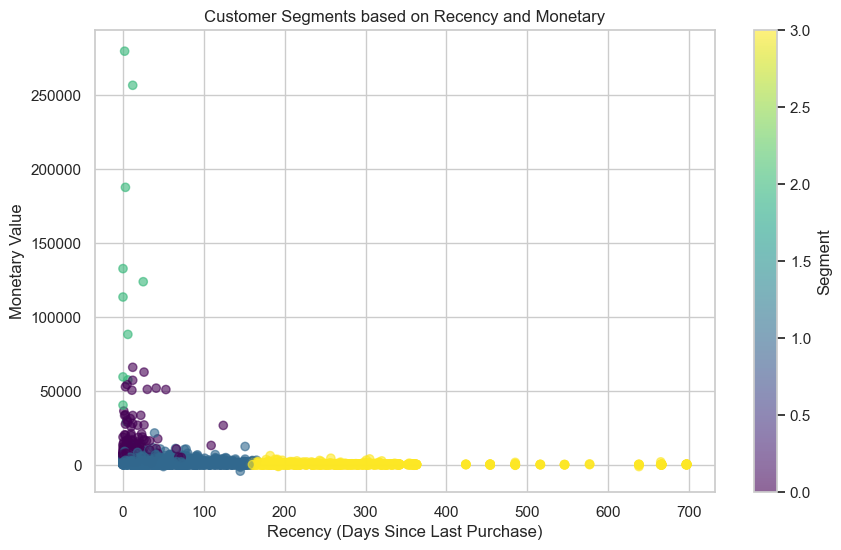

In [88]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Ensure the RFM dataframe has no missing values
rfm_df.dropna(subset=['Recency', 'Frequency', 'Monetary'], inplace=True)

# Standardize the data (important for clustering)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Apply K-means clustering (let's assume we want 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)

# Display the segments with the RFM values
print("Customer Segments based on RFM analysis:")
print(rfm_df[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment']].head())

# Optional: Visualize the segments (2D plot for Recency and Monetary)
plt.figure(figsize=(10, 6))
plt.scatter(rfm_df['Recency'], rfm_df['Monetary'], c=rfm_df['Segment'], cmap='viridis', alpha=0.6)
plt.title('Customer Segments based on Recency and Monetary')
plt.xlabel('Recency (Days Since Last Purchase)')
plt.ylabel('Monetary Value')
plt.colorbar(label='Segment')
plt.show()


8. Returns and Refunds

No relevant data

9. Profitability Analysis

No relevant data

10. Customer Satisfaction

No relevant data